<a href="https://colab.research.google.com/github/Teuteu666/XAI/blob/main/explainableAI_for_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lailaelouedeghyry","key":"4a4e0ab5e97a00ea12c2480eee5930c5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

 99% 376M/380M [00:02<00:00, 156MB/s]
100% 380M/380M [00:02<00:00, 149MB/s]


In [ ]:
!mkdir -p /content
!unzip -q augmented-alzheimer-mri-dataset.zip -d /content

#<h1>Load Model

In [ ]:
from keras.applications.resnet50 import preprocess_input
import warnings

In [ ]:
from tensorflow.keras.models import load_model

model_path = 'model_xai_2.h5'

model = load_model(model_path)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

#<h1>Explain the model using Shap technique

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
import shap
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap

def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0, 1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out

def f(z, model, segments_slic, img_orig):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

def explain_image(image_path, model):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    pred = model.predict(img_array)

    top_preds = np.argsort(-pred)
    inds = top_preds[0]

    classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
    probs_array = np.array(pred[0])
    predicted_class_index = np.argmax(pred)
    predicted_class = classes[predicted_class_index]
    print(predicted_class_index)

    print(f'Predicted Class: {predicted_class}')

    img_orig = image.img_to_array(img)
    segments_slic = slic(img, n_segments=100, compactness=30, sigma=3)

    explainer = shap.KernelExplainer(lambda z: f(z, model, segments_slic, img_orig), np.zeros((1, 100)))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shap_values = explainer.shap_values(np.ones((1, 100)), nsamples=1000)

    colors = [(0, 0, 1, l) for l in np.linspace(1, 0, 100)]
    colors += [(1, 0, 0, l) for l in np.linspace(0, 1, 100)]
    cm = LinearSegmentedColormap.from_list("shap", colors)


    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:, :-1])) for i in range(len(shap_values))])

    for i in range(4):
        m = fill_segmentation(shap_values[inds[i]][0], segments_slic)


        class_name = classes[inds[i]]

        axes[i + 1].set_title(class_name)
        axes[i + 1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i + 1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i + 1].axis('off')

    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    plt.show()


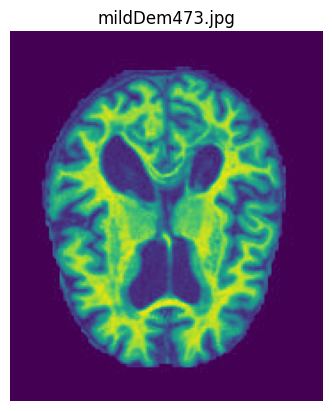

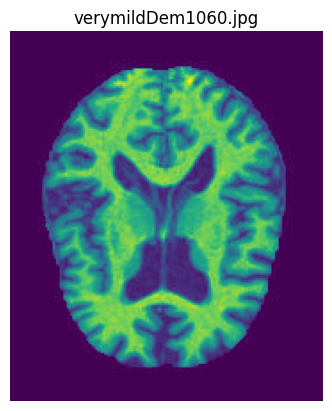

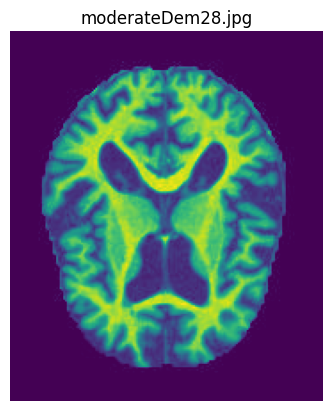

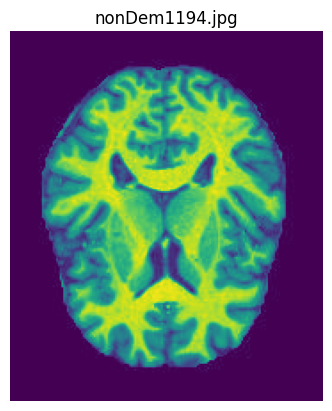

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = ['/content/OriginalDataset/MildDemented/mildDem473.jpg','/content/OriginalDataset/VeryMildDemented/verymildDem1060.jpg',"/content/OriginalDataset/ModerateDemented/moderateDem28.jpg",'/content/OriginalDataset/NonDemented/nonDem1194.jpg']

for img_path in image_paths:

    img = mpimg.imread(img_path)

    img_filename = img_path.split('/')[-1]

    plt.imshow(img)
    plt.title(img_filename)
    plt.axis('off')
    plt.show()



1/1 [==============================] - 0s 24ms/step
3
Predicted Class: VeryMildDemented
1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 3s 92ms/step


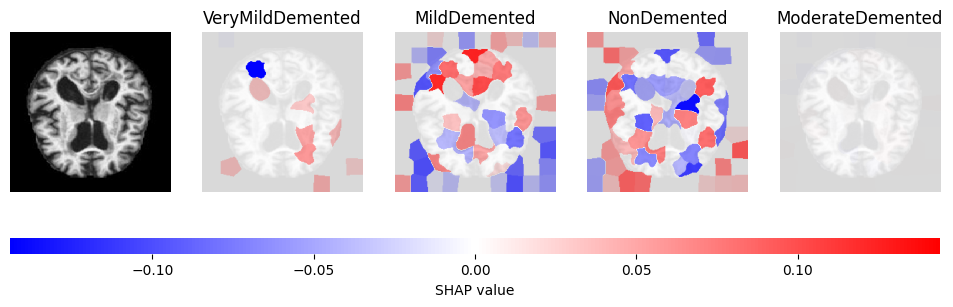

1/1 [==============================] - 0s 22ms/step
3
Predicted Class: VeryMildDemented
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 3s 92ms/step


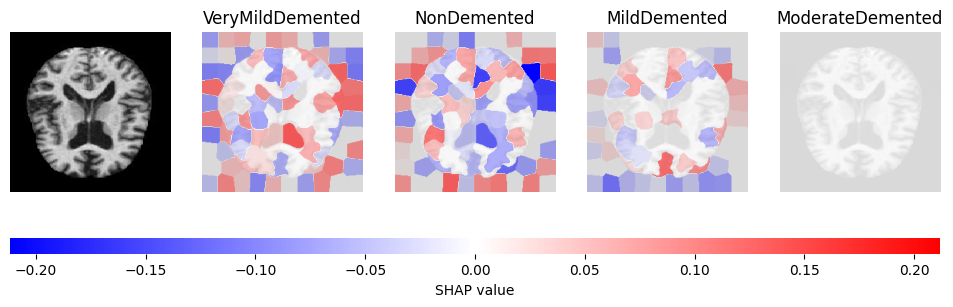

1/1 [==============================] - 0s 23ms/step
1
Predicted Class: ModerateDemented
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 3s 94ms/step


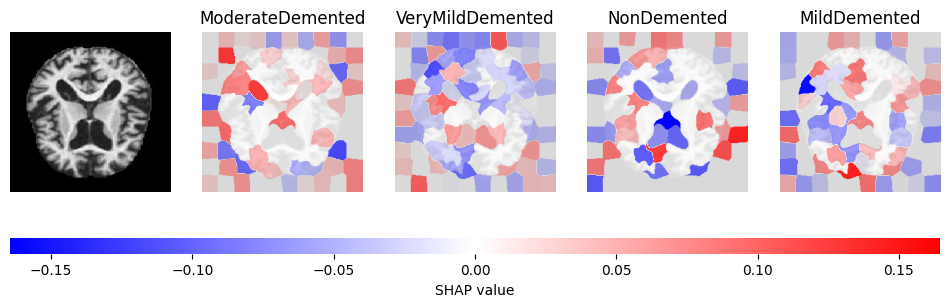

1/1 [==============================] - 0s 39ms/step
2
Predicted Class: NonDemented
1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 3s 93ms/step


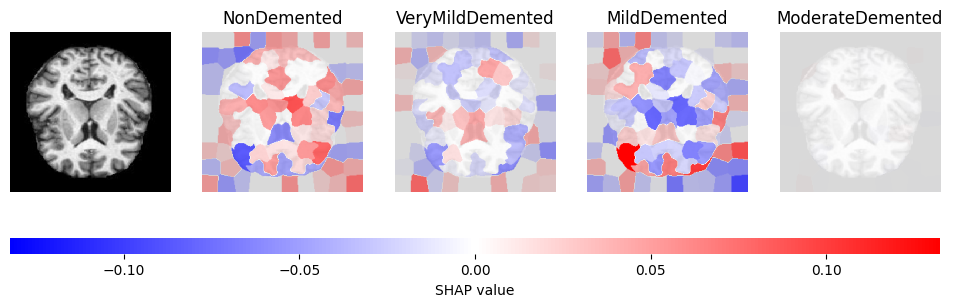

In [ ]:
images = ['/content/OriginalDataset/MildDemented/mildDem473.jpg','/content/OriginalDataset/VeryMildDemented/verymildDem1060.jpg',"/content/OriginalDataset/ModerateDemented/moderateDem28.jpg",'/content/OriginalDataset/NonDemented/nonDem1194.jpg']
for image_path in images:
  explain_image(image_path, model)

#<h1>Explain the model using Grad Cam technique

In [ ]:
!pip install tf_keras_vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 891.5 kB/s eta 0:00:00


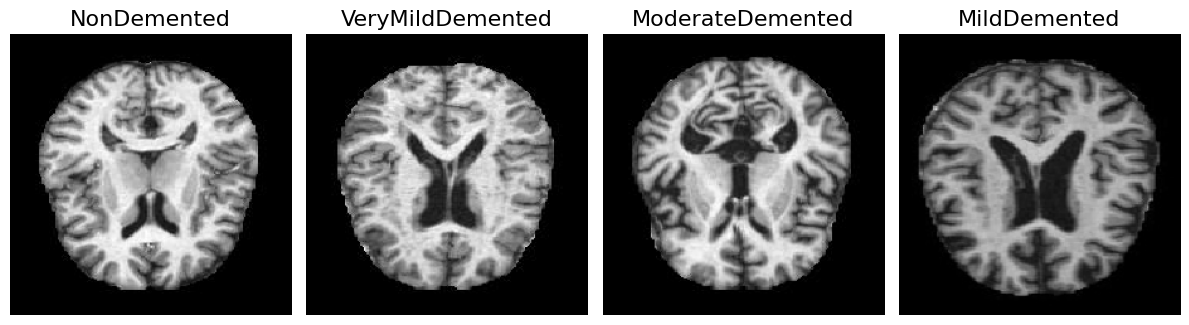

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
image_titles = ['NonDemented', 'VeryMildDemented','ModerateDemented','MildDemented']

img1 = load_img('/content/OriginalDataset/NonDemented/nonDem1320.jpg', target_size=(224, 224))
img2 = load_img('/content/OriginalDataset/VeryMildDemented/verymildDem1403.jpg', target_size=(224, 224))
img3 = load_img('/content/OriginalDataset/ModerateDemented/moderateDem13.jpg', target_size=(224, 224))
img4 = load_img('/content/AugmentedAlzheimerDataset/MildDemented/1b4e9385-43ff-4858-bf1a-d9d056a2ba83.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4)])

X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 35ms/step


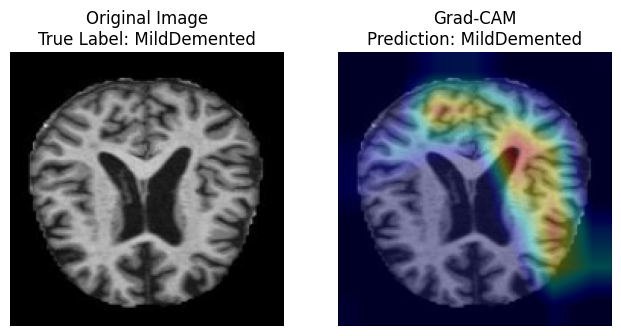

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from keras.preprocessing import image
import matplotlib.pyplot as plt

def get_grad_cam(model, img_path, label_idx=None, layer_name=None):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)


    if label_idx is None:
        preds = model.predict(img_array)
        label_idx = np.argmax(preds)


    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(layer_name).output, model.output])


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, label_idx]

    output = conv_outputs[0]

    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = tf.reduce_sum(output * weights, axis=2)

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return overlaid_img

def explain_with_grad_cam(model, class_names, img_path, label_idx=None, layer_name=None):
    heatmap = get_grad_cam(model, img_path, label_idx, layer_name)
    overlaid_img = overlay_grad_cam(img_path, heatmap)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds)
    predicted_class = class_names[predicted_class_idx]


    true_label = img_path.split('/')[-2]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPrediction: {predicted_class}")
    plt.axis("off")

    plt.show()
class_names=['MildDemented','ModerateDemented','NonDemented', 'VeryMildDemented']
image_path = '/content/AugmentedAlzheimerDataset/MildDemented/1b4e9385-43ff-4858-bf1a-d9d056a2ba83.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')


1/1 [==============================] - 0s 22ms/step


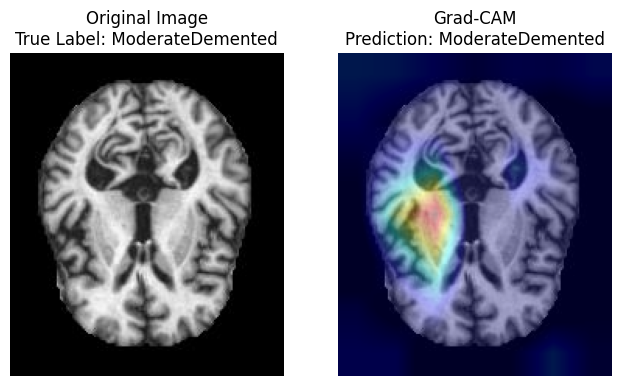

In [ ]:
image_path ='/content/OriginalDataset/ModerateDemented/moderateDem13.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 23ms/step


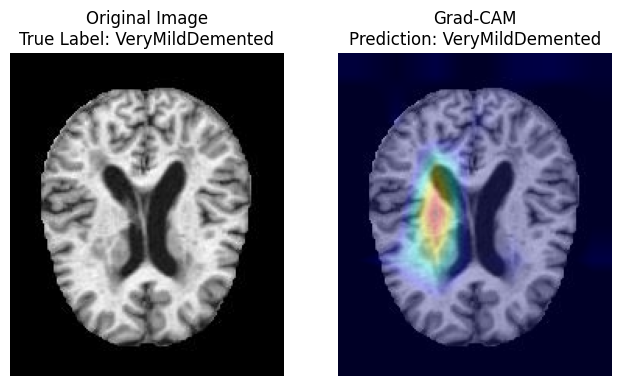

In [ ]:
image_path ='/content/OriginalDataset/VeryMildDemented/verymildDem1479.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 24ms/step


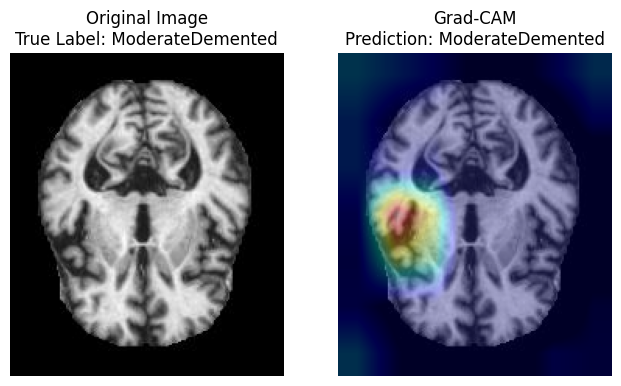

In [ ]:
image_path ='/content/OriginalDataset/ModerateDemented/moderateDem7.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

1/1 [==============================] - 0s 27ms/step


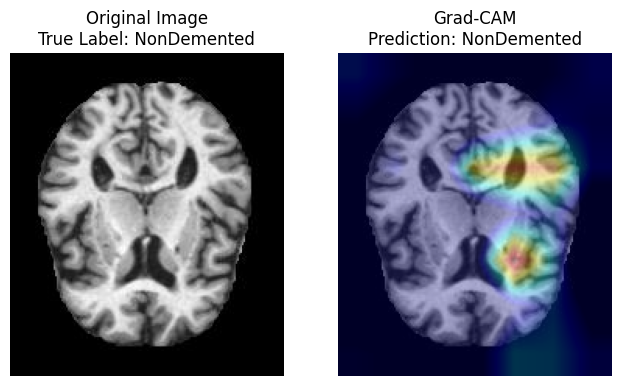

In [ ]:
image_path ='/content/OriginalDataset/NonDemented/nonDem1131.jpg'
explain_with_grad_cam(model,class_names, image_path, layer_name='conv5_block3_3_conv')

#<h1>Explain the model using Lime technique

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=235da24d39ed3dda2085305dda5525381c8ec756c9e27cd9e826c02d791b3715
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


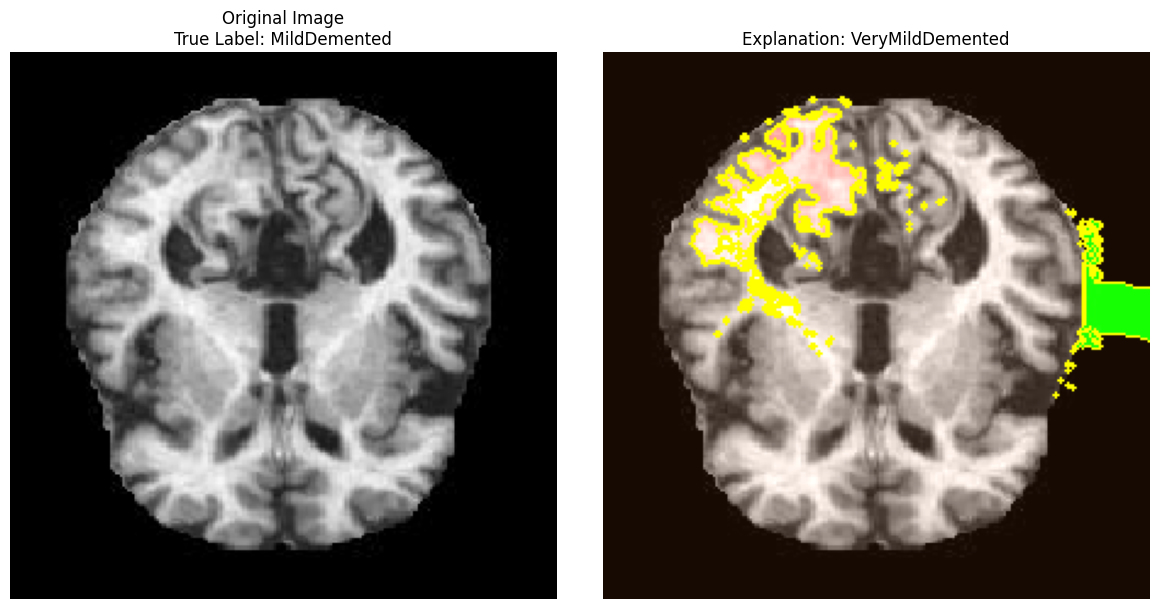

Model Predictions:
MildDemented: 0.3075
ModerateDemented: 0.0120
NonDemented: 0.2719
VeryMildDemented: 0.4086




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


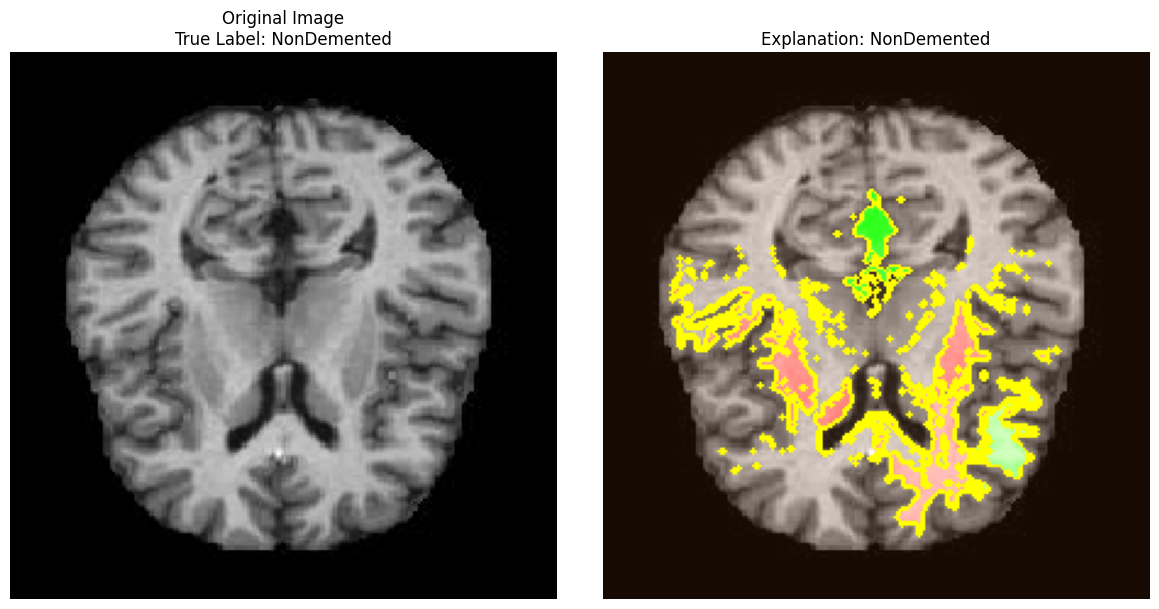

Model Predictions:
MildDemented: 0.0000
ModerateDemented: 0.0000
NonDemented: 1.0000
VeryMildDemented: 0.0000




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


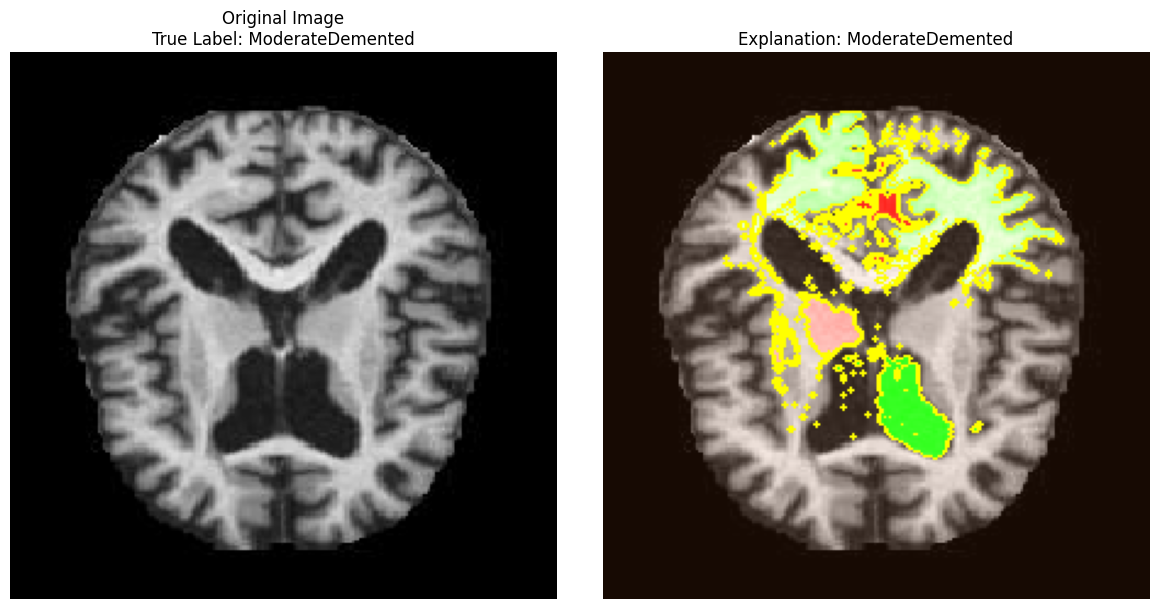

Model Predictions:
MildDemented: 0.0002
ModerateDemented: 0.9996
NonDemented: 0.0001
VeryMildDemented: 0.0002




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


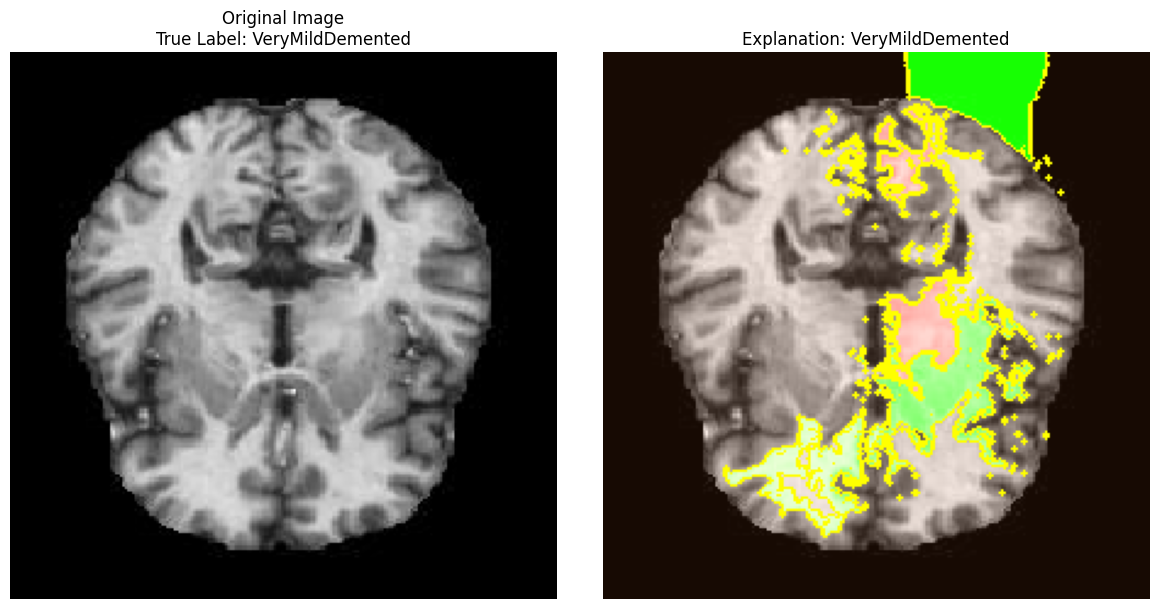

Model Predictions:
MildDemented: 0.0002
ModerateDemented: 0.0000
NonDemented: 0.0021
VeryMildDemented: 0.9977




In [ ]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.morphology import disk
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def explain_and_visualize(model, image_paths, class_names, num_samples=1000, num_features=5):

    explainer = lime_image.LimeImageExplainer()

    for image_path in image_paths:

        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)


        def predict_fn(images):
            return model.predict(images)

        explanation = explainer.explain_instance(
            img_array[0],
            predict_fn,
            top_labels=1,
            num_samples=num_samples
        )
        true_label = image_path.split('/')[-2]

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=num_features,
            hide_rest=False
        )

        preds = model.predict(img_array)
        predicted_class_idx = np.argmax(preds)
        predicted_class = class_names[predicted_class_idx]
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original Image\nTrue Label: {true_label}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mark_boundaries(temp / 255 + 0.5, mask))
        plt.title(f"Explanation: {predicted_class}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print("Model Predictions:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {preds[0][i]:.4f}")
        print("\n")


class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
image_paths = ['/content/OriginalDataset/MildDemented/mildDem139.jpg', '/content/OriginalDataset/NonDemented/nonDem1020.jpg', '/content/OriginalDataset/ModerateDemented/moderateDem32.jpg', '/content/OriginalDataset/VeryMildDemented/verymildDem142.jpg']

explain_and_visualize(model, image_paths, class_names)
